In [1]:
import pandas as pd
import time
import datetime
import glob as mod_glob
import json
import seaborn as sns
import matplotlib.pyplot as plt


# Analyse segment statistics

In [82]:
# Read meta-data for all segments
datadir = 'data/'
segfile = 'segments/segments.csv'

md = pd.read_csv(datadir + segfile)
md.drop(columns='Unnamed: 0', inplace=True)
md.set_index('id', inplace=True)


rl_ = None

# Read usage records
ridelog_files = mod_glob.glob(datadir + 'ridelogs/' + r"*.json")
for rf in ridelog_files:
    print(rf)
    jdata = []
    with open(rf) as ridelog:
        for line in ridelog:
            jdata.append(json.loads(line))
    if(rl_ is None):
        rl_ = pd.DataFrame(jdata)
    else:
        rl_ = pd.concat([rl_, pd.DataFrame(jdata)], ignore_index=True)
rl_['date'] = pd.to_datetime(rl_['time_retrieved'], unit='s').dt.date

data/ridelogs/segments-20201124.json
data/ridelogs/202011.json


In [83]:
# Get historical average user per day
c = 'created_at'
md[c] = pd.to_datetime(md[c])
c = 'time_retrieved'
md[c] = pd.to_datetime(md[c], utc=True)
md['hist_length'] = md['time_retrieved'] - md['created_at']
md['hist_length_days'] = md['hist_length'].apply(lambda x: x.days)
md['avg_daily'] = md['effort_count'] / md['hist_length_days']
md.index = md.index.map(str)

In [84]:
md[['name', 'avg_daily']]

,name,avg_daily
id,,
3808938,קפוצינו,6.065780
1248017,העלייה מרון,4.205030
4267589,מה עכשיו טיפוס,6.650073
18952377,שימרי,7.628644
2481821,מעלה רמי,10.131048
7774409,fun in the forest,18.416558
8574425,החילזון נהיה עצלן,7.128146
17421855,ברמים בירידה,14.519494
4202076,פאמפ טראק ריש לקיש,7.136911


In [85]:
# Tabulate ridelog data with date as index
rl2 = pd.pivot_table(rl_, index='date', values='effort_count', columns='segment_id')
rl2.set_index(pd.DatetimeIndex(rl2.index.values), inplace=True)

In [86]:
# resample daily, interpolate missing values, and diff against the previous day
daily = rl2.resample('1D').interpolate().fillna(method='bfill').diff()


In [111]:
# add the daily average in each segment

# first, convert the table to long format
all_segs = daily.columns
d2 = daily.reset_index()
d3 = d2.melt(id_vars = 'index', value_vars=all_segs)
d4 = d3.rename(columns = {'index' : 'date'})

# tack on the daily averages
d5 = d4.merge(md['avg_daily'], how='inner', left_on='segment_id', right_on='id')
# compute usage relative to the daily average
d5['relative_usage'] = d5['value'] / d5['avg_daily']
d6 = d5[['date', 'segment_id', 'relative_usage']]

# re-tabulate
d7 = pd.pivot_table(d6, index='date', values='relative_usage', columns='segment_id')
d8 = d7.clip(lower=0, upper=1)
d8


segment_id,1248017,1717839,17421855,17443790,18952377,2481821,3808938,4202076,4267589,7774409,8574425
date,,,,,,,,,,,
2020-11-25,1.000000,1.000000,1.000000,0.604620,0.655424,1.0,0.494578,1.000000,1.000000,1.000000,1.000000
2020-11-26,0.000000,0.000000,0.000000,0.109931,0.000000,0.0,0.164859,0.000000,0.150374,0.000000,0.140289
2020-11-27,0.237810,0.241739,0.413238,0.879447,0.000000,1.0,1.000000,0.000000,0.601497,0.868783,0.561156
2020-11-28,0.713431,0.241739,0.344365,0.879447,0.786509,1.0,1.000000,0.560467,1.000000,1.000000,1.000000
2020-11-29,0.951242,0.000000,0.206619,0.054965,0.786509,1.0,1.000000,0.840700,1.000000,1.000000,0.420867
2020-11-30,1.000000,1.000000,0.344365,0.549655,0.393255,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


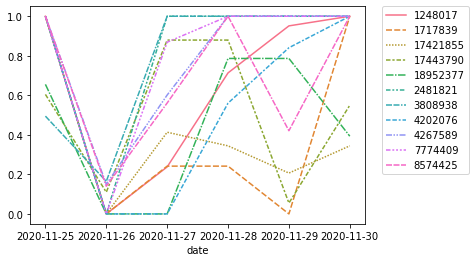

In [113]:
sns.lineplot(data=d8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#d7